# Quantum Convolutional Neural Network

*This* project implements a simplifiedQuantum Convolutional Neural Network</a> (QCNN), a proposed quantum analogue to a classical convolutional neural network



In [3]:
!pip install tensorflow==2.8.0

Install TensorFlow Quantum:

In [4]:
!pip install tensorflow-quantum==0.7.3

In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [6]:
pip install tensorflow-quantum


In [10]:
! pip uninstall tensorflow-quantum



Found existing installation: tensorflow-quantum 0.7.3
Uninstalling tensorflow-quantum-0.7.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/tensorflow_quantum-0.7.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow_quantum/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 680, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 375, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/p

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## QCNN construction

### Assemble circuits in a TensorFlow graph

TensorFlow Quantum (TFQ) provides layer classes designed for in-graph circuit construction. One example is the `tfq.layers.AddCircuit` layer that inherits from `tf.keras.Layer`. This layer can either prepend or append to the input batch of circuits, as shown in the following figure.

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/qcnn_1.png?raw=1" width="700">



In [11]:
! pip install -q kaggle


In [ ]:
from google.colab import files

files.upload()

In [12]:
! mkdir ~/.kaggle

In [13]:
!pip install opendatasets
!pip install pandas

In [14]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: swaralipidatta
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:32<00:00, 75.3MB/s]


In [16]:

# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [17]:
# Generate data paths with labels
data_dir = '/content/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [18]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [19]:
# crobed image size
batch_size = 16
img_size = (1858 , 2090)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


In [20]:
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

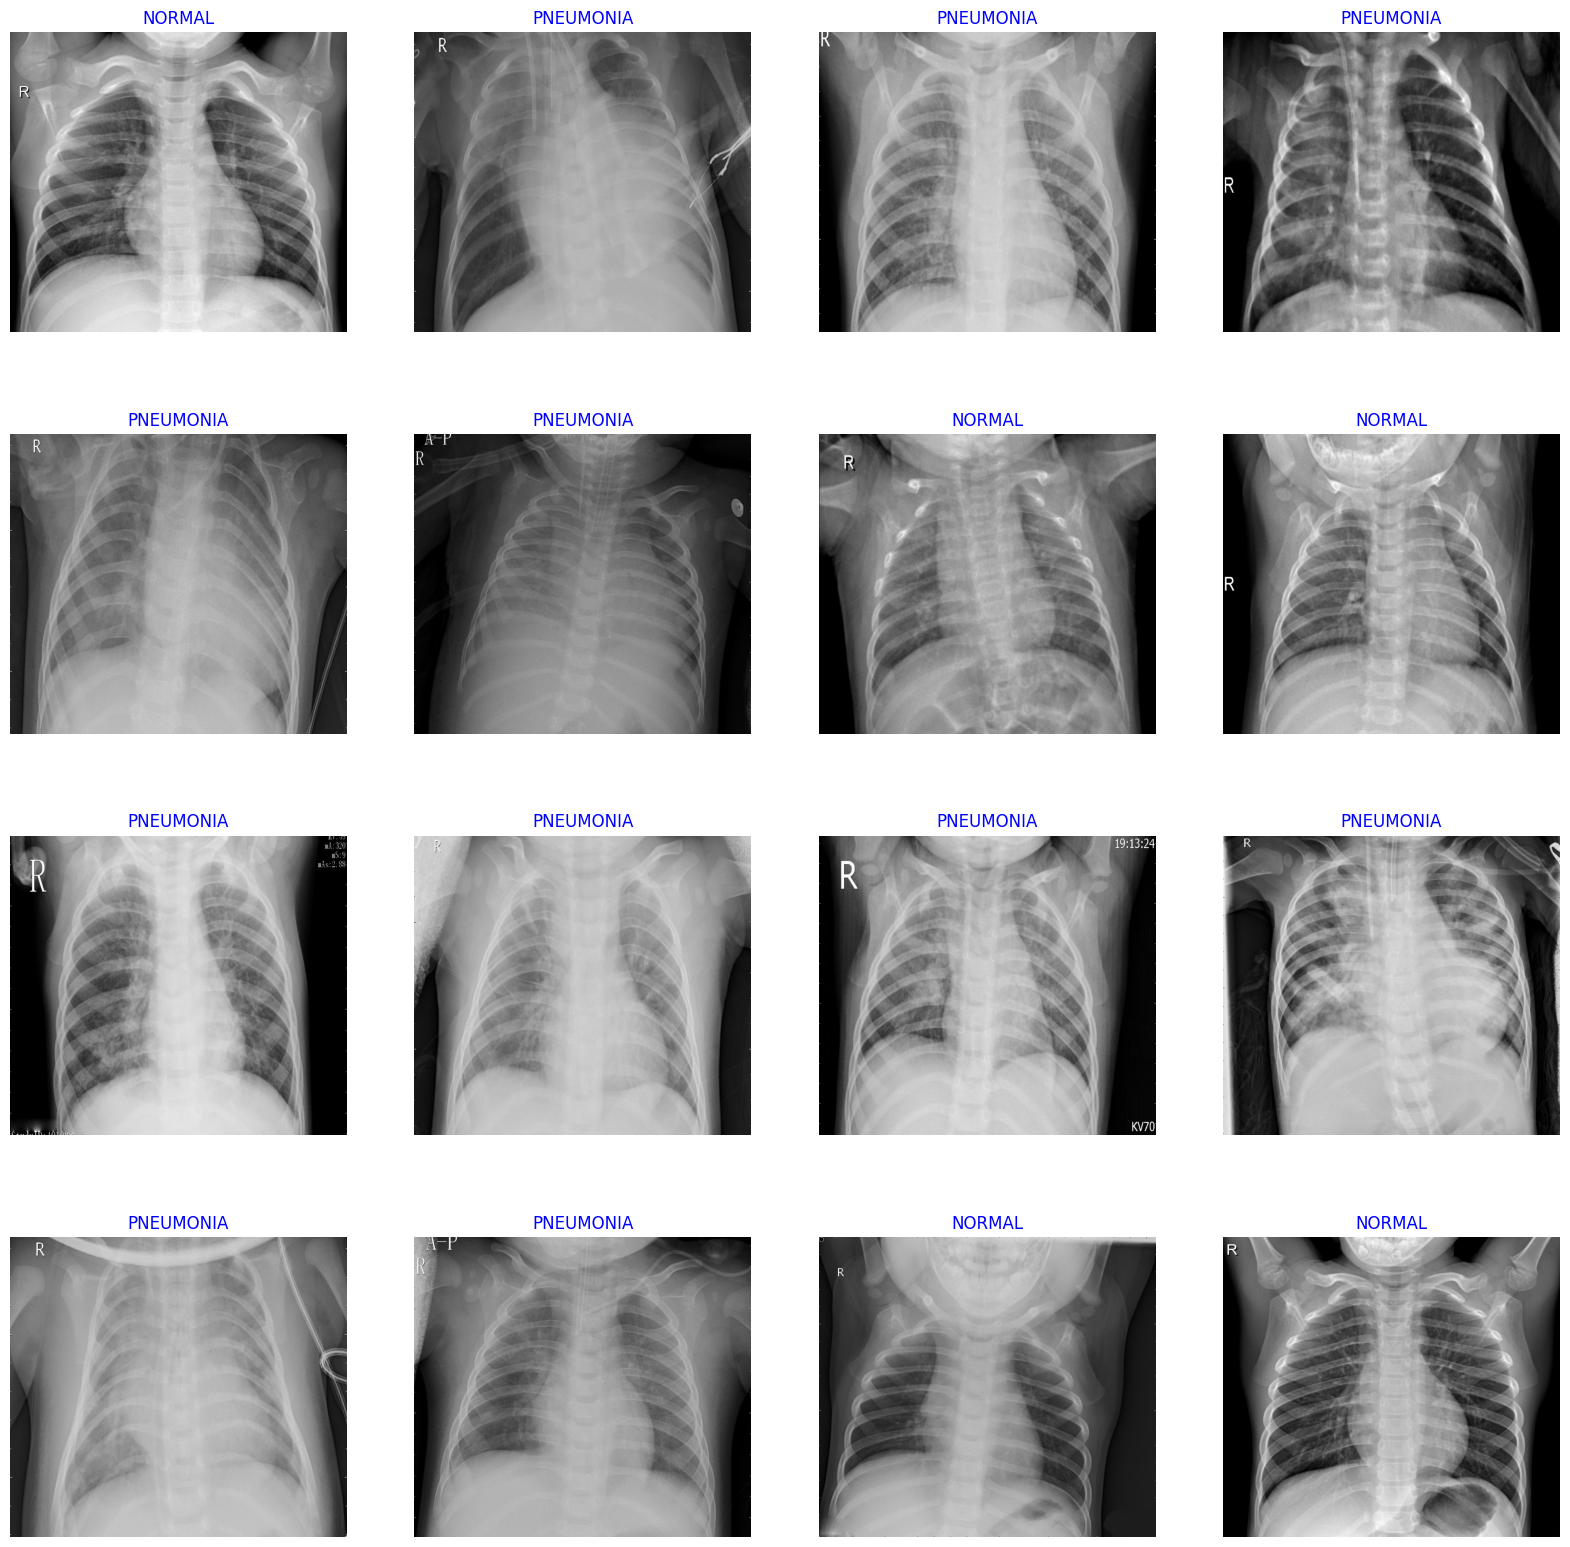

In [21]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd #
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
#     return np.array(data)
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest-xray-pneumonia/chest_xray/train')
val = get_training_data('/content/chest-xray-pneumonia/chest_xray/val')
test = get_training_data('/content/chest-xray-pneumonia/chest_xray/val')

Text(0.5, 1.0, 'NORMAL')

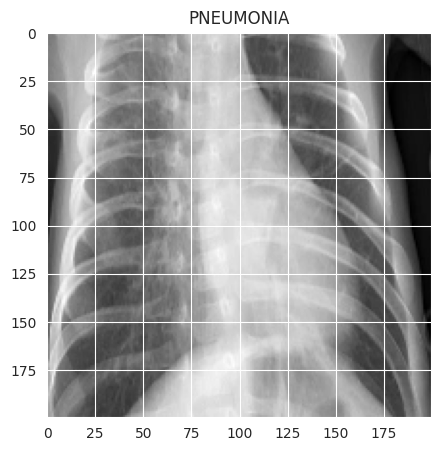

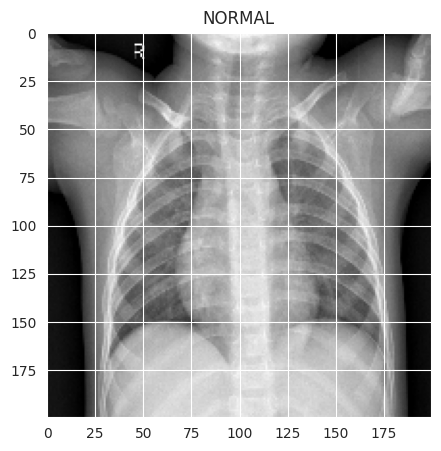

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(train[0][0], cmap = 'gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1][0], cmap = 'gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test =[]
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in train:
    x_test.append(feature)
    y_test.append(label)


In [ ]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [ ]:
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)
y_train
x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
x_train= tf.cast(x_train, tf.float32)
x_test=tf.cast(x_test, tf.float32)

x_train = tf.image.resize(x_train[:], (10,10)).numpy()
x_test = tf.image.resize(x_test[:], (10,10)).numpy()

y_train = y_train[:]
y_test = y_test[:]

0


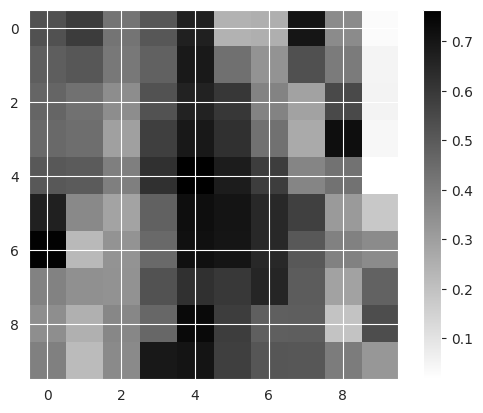

In [ ]:
print(y_train[0])
fig = plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray_r')
plt.colorbar()
fig.savefig('sample', dpi=300)

In [ ]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

fc_model = models.Sequential()

fc_model.add(layers.Flatten(input_shape=(width,height,1)))
fc_model.add(layers.Dense(32, activation='relu'))
fc_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
fc_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fc_history = fc_model.fit(x_train, y_train, steps_per_epoch=100,
                        validation_data=(x_test, y_test),
                        epochs=50, batch_size=5)

Epoch 1/50
100/100 [==============================] - 4s 32ms/step - loss: 0.2938 - accuracy: 0.8800 - val_loss: 0.3007 - val_accuracy: 0.8901
Epoch 2/50
100/100 [==============================] - 1s 13ms/step - loss: 0.2791 - accuracy: 0.9000 - val_loss: 0.2627 - val_accuracy: 0.8976
Epoch 3/50
100/100 [==============================] - 1s 13ms/step - loss: 0.2564 - accuracy: 0.8900 - val_loss: 0.2654 - val_accuracy: 0.9022
Epoch 4/50
100/100 [==============================] - 1s 15ms/step - loss: 0.2581 - accuracy: 0.8980 - val_loss: 0.3894 - val_accuracy: 0.8275
Epoch 5/50
100/100 [==============================] - 3s 28ms/step - loss: 0.2588 - accuracy: 0.9100 - val_loss: 0.2454 - val_accuracy: 0.8978
Epoch 6/50
100/100 [==============================] - 6s 59ms/step - loss: 0.2609 - accuracy: 0.9000 - val_loss: 0.2349 - val_accuracy: 0.9062
Epoch 7/50
100/100 [==============================] - 5s 55ms/step - loss: 0.2478 - accuracy: 0.9020 - val_loss: 0.2301 - val_accuracy: 0.9089

In [ ]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(width, height, 1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 9, 9, 8)           40        
                                                                 
 flatten_6 (Flatten)         (None, 648)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                20768     
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 21,138
Trainable params: 21,138
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_history = cnn_model.fit(x_train, y_train, steps_per_epoch=100,
                        validation_data=(x_test, y_test),
                        epochs=50, batch_size=5)

Epoch 1/50
100/100 [==============================] - 3s 30ms/step - loss: 0.7855 - accuracy: 0.7000 - val_loss: 0.5294 - val_accuracy: 0.7429
Epoch 2/50
100/100 [==============================] - 3s 30ms/step - loss: 0.5084 - accuracy: 0.7420 - val_loss: 0.4534 - val_accuracy: 0.7523
Epoch 3/50
100/100 [==============================] - 3s 30ms/step - loss: 0.4334 - accuracy: 0.8060 - val_loss: 0.4319 - val_accuracy: 0.7527
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 0.3985 - accuracy: 0.8340 - val_loss: 0.3497 - val_accuracy: 0.8367
Epoch 5/50
100/100 [==============================] - 2s 15ms/step - loss: 0.3502 - accuracy: 0.8640 - val_loss: 0.3306 - val_accuracy: 0.8340
Epoch 6/50
100/100 [==============================] - 2s 15ms/step - loss: 0.3316 - accuracy: 0.8640 - val_loss: 0.3836 - val_accuracy: 0.8039
Epoch 7/50
100/100 [==============================] - 1s 14ms/step - loss: 0.2671 - accuracy: 0.8900 - val_loss: 0.2575 - val_accuracy: 0.9001

In [ ]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)

163/163 - 0s - loss: 0.1558 - accuracy: 0.9415 - 426ms/epoch - 3ms/step


In [ ]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param

    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])

    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        pixels = self.filter_size**2
        # filter size: 2^n only for this version!
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])

    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1

        self.kernel = self.add_weight(name="kenel",
                                      shape=[self.depth,
                                             self.channel,
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)

    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]

        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y]

        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)

    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs,
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)


In [ ]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

qcnn_model = models.Sequential()


qcnn_model.add(QConv(filter_size=2, depth=8, activation='relu',
                     name='qconv1', input_shape=(width, height, 1)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
qcnn_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
qcnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qconv1 (QConv)              (None, 9, 9, 8)           48        
                                                                 
 flatten_5 (Flatten)         (None, 648)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                20768     
                                                                 
 dense_11 (Dense)            (None, 10)                330       
                                                                 
Total params: 21,146
Trainable params: 21,146
Non-trainable params: 0
_________________________________________________________________


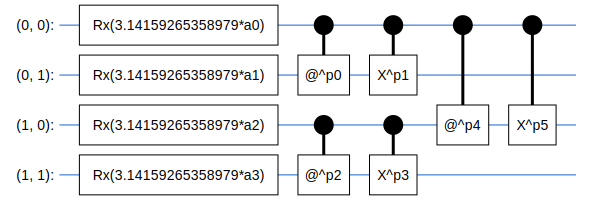

In [ ]:
SVGCircuit(QConv(filter_size=2, depth=0, activation='relu').circuit)

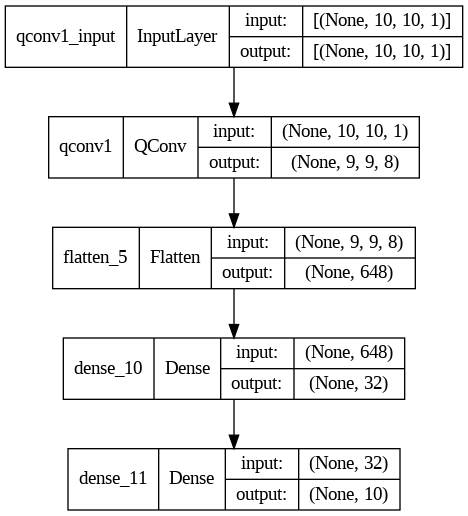

In [ ]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(qcnn_model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train, steps_per_epoch=100,
                        validation_data=(x_test, y_test),
                        epochs=10, batch_size=5)

Epoch 1/10
100/100 [==============================] - 591s 6s/step - loss: 0.6550 - accuracy: 0.7720 - val_loss: 0.5285 - val_accuracy: 0.7429
Epoch 2/10
100/100 [==============================] - 605s 6s/step - loss: 0.4991 - accuracy: 0.7580 - val_loss: 0.4989 - val_accuracy: 0.7429
Epoch 3/10
100/100 [==============================] - 558s 6s/step - loss: 0.4993 - accuracy: 0.7740 - val_loss: 0.4413 - val_accuracy: 0.8832
Epoch 4/10
100/100 [==============================] - 560s 6s/step - loss: 0.3888 - accuracy: 0.8360 - val_loss: 0.3760 - val_accuracy: 0.8890
Epoch 5/10
100/100 [==============================] - 558s 6s/step - loss: 0.3417 - accuracy: 0.8760 - val_loss: 0.3324 - val_accuracy: 0.8449
Epoch 6/10
100/100 [==============================] - 560s 6s/step - loss: 0.3346 - accuracy: 0.8720 - val_loss: 0.2972 - val_accuracy: 0.9020
Epoch 7/10
100/100 [==============================] - 556s 6s/step - loss: 0.3274 - accuracy: 0.8580 - val_loss: 0.3132 - val_accuracy: 0.8959

In [ ]:
test_loss, test_acc = qcnn_model.evaluate(x_test, y_test, verbose=2)

163/163 - 459s - loss: 0.2362 - accuracy: 0.9066 - 459s/epoch - 3s/step


In [ ]:
for i in range(8):
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(qcnn_model.get_layer('qconv1')(x_train[0:1,:,:,:])[0,:,:,i], cmap='gray_r')
    fig.savefig('qcnn_%d'%i, dpi=300, bbox_inches='tight')

In [ ]:
def plot_loss_curves(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss)) + 1, fc_loss, "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_loss)) + 1, cnn_loss, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss)) + 1, qcnn_loss, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss.png', dpi=300)

def plot_loss_curves_small(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss))[::2] + 1, fc_loss[::2], "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_loss))[::2] + 1, cnn_loss[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss))[::2] + 1, qcnn_loss[::2], "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss_small.png', dpi=300)

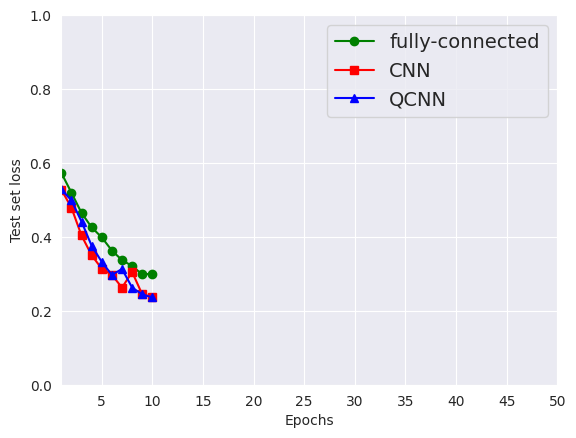

In [ ]:
plot_loss_curves(fc_history.history['val_loss'], cnn_history.history['val_loss'], qcnn_history.history['val_loss'])


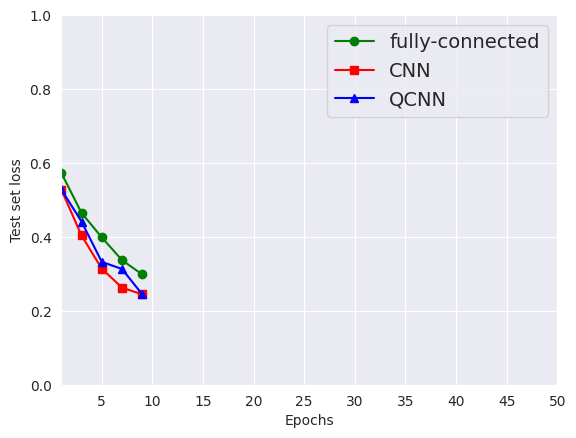

In [ ]:
plot_loss_curves_small(fc_history.history['val_loss'], cnn_history.history['val_loss'], qcnn_history.history['val_loss'])


In [ ]:
def plot_acc_curves(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc)) + 1, fc_acc, "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_acc)) + 1, cnn_acc, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc)) + 1, qcnn_acc, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0.8, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy.png', dpi=300)

def plot_acc_curves_small(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc))[::2] + 1, fc_acc[::2], "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_acc))[::2] + 1, cnn_acc[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc))[::2] + 1, qcnn_acc[::2], "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0.8, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy_small.png', dpi=300)

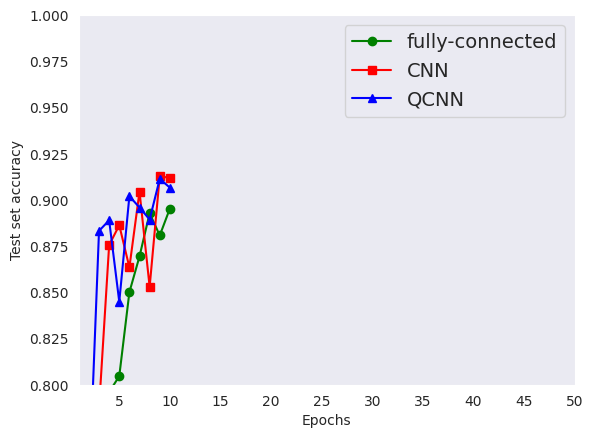

In [ ]:
plot_acc_curves(fc_history.history['val_accuracy'], cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])


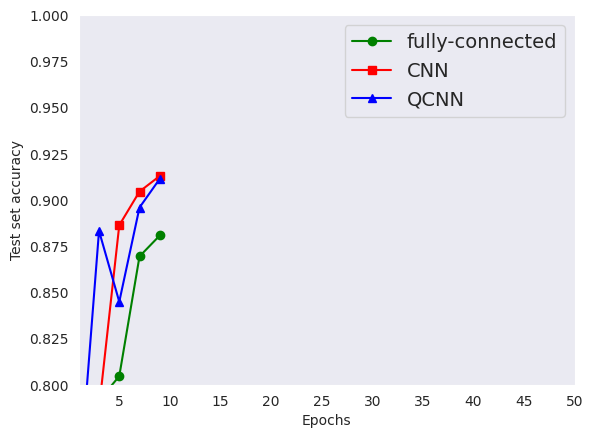

In [ ]:
plot_acc_curves_small(fc_history.history['val_accuracy'], cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])
